# Подготовка

Это предварительные действия, которые лучше выполнить перед семинаром!

1. Скачать файл с моделью AdaGram для русского языка по [ссылке](https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib)
2. Переместить файл из п. 1 в папку с этой тетрадкой
3. Скачать архив с моделью ELMo для русского языка по [ссылке](http://vectors.nlpl.eu/repository/20/196.zip)
4. Распаковать архив в папку с этой тетрадкой
5. Скачать в папку с этой тетрадкой дополнительные файлы [из репозитория курса](https://github.com/named-entity/hse-nlp/tree/master/4th_year/seminar/5_WSD)
6. Установить необходимые библиотеки (ячейки ниже)

P.S. Можно проделать всё это в Colab'е, но там есть проблемы с запуском MyStem :(

In [ ]:
!pip install tensorflow Cython matplotlib

In [ ]:
!pip install simple-elmo

In [ ]:
!pip install git+https://github.com/lopuhin/python-adagram.git

In [ ]:
!pip install pymystem3 pymorphy2

In [1]:
# библиотеки для работы с эмбеддингами
import adagram
from simple_elmo import ElmoModel

# обработка данных и ML
import pandas as pd
from lxml import html
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from tqdm.notebook import tqdm
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import *
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')
stops = set(stopwords.words('russian'))

def normalize(text):
    words = [morph.parse(word)[0].normal_form for word in tokenize(text) if word]
    return words

def tokenize(text):
    return token.tokenize(text)

## Адаграм

Word2Vec и многие другие векторные модели сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. 

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопоставлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова.

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

In [ ]:
#!curl "https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib" > all.a010.p10.d300.w5.m100.nonorm.slim.joblib

In [3]:
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

Посмотрим на значения каких-нибудь слов: эти "значения"  задаются индексами, у каждого есть вероятность.

In [4]:
vm.word_sense_probs('вечер')

[(0, 0.13080149644282904),
 (1, 0.21073024350994726),
 (2, 0.2956921249405029),
 (3, 0.14701596077005963),
 (4, 0.21575999977552957)]

Посмотрим какие слова близки к каждому из значений.

In [5]:
vm.sense_neighbors('вечер', 0)

[('концерт', 0, 0.7144409),
 ('абонемент', 2, 0.6624344),
 ('гала-концерт', 0, 0.6443357),
 ('программа', 5, 0.64056844),
 ('бал', 0, 0.6292274),
 ('музыкально-поэтический', 0, 0.60767984),
 ('выступление', 2, 0.60689574),
 ('цдри', 0, 0.60517657),
 ('состояться', 1, 0.594547),
 ('органный', 0, 0.5825637)]

In [6]:
vm.sense_neighbors('вечер', 1)

[('утро', 3, 0.7549074),
 ('ночь', 0, 0.72731614),
 ('полдень', 0, 0.6854935),
 ('зимний', 1, 0.6458328),
 ('апрельский', 1, 0.63833475),
 ('летний', 0, 0.61566144),
 ('августовский', 1, 0.61506253),
 ('погожий', 0, 0.60568976),
 ('осенний', 0, 0.60227585),
 ('январский', 0, 0.59733826)]

In [7]:
vm.sense_neighbors('вечер', 2)

[('ночь', 3, 0.75746113),
 ('утро', 2, 0.7372704),
 ('завтра', 1, 0.65727353),
 ('сегодня', 2, 0.61901164),
 ('утро', 6, 0.58885354),
 ('день', 0, 0.5881707),
 ('вчера', 1, 0.586063),
 ('обед', 3, 0.578071),
 ('полдень', 3, 0.5492313),
 ('приходить', 0, 0.5457571)]

In [8]:
context = "Сегодня вечером я иду в гости."

ВОПРОС! Как можно дизамбигуировать контексты, используя соседей для каждого значения?

Можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [10]:
ambiguous = []
for i, word in enumerate(vm.dictionary.id2word):
    probs = vm.word_sense_probs(word)
    if len(probs) > 1:
        ambiguous.append(word)
    if i > 1000:
        break
print(ambiguous[-50:])

['болезнь', 'владимир', 'рот', '25', 'исторический', 'сохранять', 'примерно', 'требование', 'сезон', 'руководство', 'глубокий', '18', 'обладать', 'база', 'см', 'содержание', 'бежать', 'существо', 'удовольствие', 'приобретать', 'низкий', 'князь', 'сотрудник', 'едва', 'радость', 'сергей', 'сообщение', 'здоровье', 'близко', 'продавать', 'постоянный', 'миллион', 'учиться', 'короткий', 'вскоре', 'пространство', 'зеленый', 'товарищ', 'губа', 'бумага', 'южный', 'одновременно', 'германия', 'прошлый', 'февраль', 'крайний', 'отсутствие', 'директор', 'посылать', 'бизнес']


Дизамбигуация AdaGram основана на вычислении вероятности вектора каждого значения в заданном контексте. 

Функция `model.disambiguate` возвращает массив вероятностей для всех значения данного слова:

In [19]:
context = "Ради любви родителей, ради того, чтобы они снова также танцевали в их гостиной, наслаждаясь милыми семейными"
means = vm.disambiguate(
    'вечер', 
    normalize(context)
)

In [20]:
means

array([4.33055643e-05, 9.33966936e-02, 1.18993990e-01, 2.09879331e-09,
       7.87566009e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

Чтобы выяснить, какое значение выбрал AdaGram, нужно найти индекс вектора с максимальной вероятностью:

In [21]:
i = np.argmax(means)
vm.sense_neighbors('вечер', i)

[('ночь', 2, 0.71722674),
 ('утро', 0, 0.67342365),
 ('воскресение', 2, 0.6373367),
 ('утро', 5, 0.63327533),
 ('выходной', 2, 0.60548764),
 ('просыпаться', 0, 0.59937185),
 ('полдень', 3, 0.5965072),
 ('пятница', 3, 0.5960661),
 ('вечерок', 0, 0.589052),
 ('обед', 1, 0.57446516)]

In [23]:
means = vm.disambiguate(
    'вечер', 
    normalize("абонемент № 19 \"Камерные \" включает в себя и концерт лауреата последнего Конкурса Чайковского")
)

In [24]:
vm.sense_neighbors('вечер', np.argmax(means))

[('концерт', 0, 0.7144409),
 ('абонемент', 2, 0.6624344),
 ('гала-концерт', 0, 0.6443357),
 ('программа', 5, 0.64056844),
 ('бал', 0, 0.6292274),
 ('музыкально-поэтический', 0, 0.60767984),
 ('выступление', 2, 0.60689574),
 ('цдри', 0, 0.60517657),
 ('состояться', 1, 0.594547),
 ('органный', 0, 0.5825637)]

## WSD / WSI
Разрешение семантической/лексической неоднозначности/омонимии

Проверим, насколько хорошо выбирается значение на данных с [соревнования Диалога](http://www.dialog-21.ru/evaluation/2018/disambiguation/) (переиспользую [baseline](https://github.com/nlpub/russe-wsi-kit) соревнования)
(А [вот](http://www.dialog-21.ru/media/5077/bolshinaasplusloukachevitchnv-108.pdf), кстати, новая статья о генерации обучающих данных для WSD)

**NB!** Большая модель AdaGram для русского языка, которую мы используем, обучена на корпусе с нормализацией *mystem*. Так что немного модифицируем нашу функцию нормализации.

In [2]:
mystem = Mystem()

def lemmatized_context(s):
    return [w.lower() for w in mystem.lemmatize(" ".join(tokenize(s)))]

def disambiguate(model, word, context):
    word, _ = lemmatized_context(word)
    probs = model.disambiguate(word, lemmatized_context(context))
    return 1 + probs.argmax()


Небольшой подкорпус RUSSE - всего 4 неоднозначных слова:

In [26]:
df = pd.read_csv('5_WSD/train.baseline-adagram.csv', sep='\t')

In [27]:
pd.set_option('display.max_colwidth', 1000)

In [28]:
df.sample(frac=0.05)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
202,203,лук,1,2,"0-3, 273-276, 349-352","лук , кроме того , был очень живуч . срок его службы исчислялся десятилетиями , а перевозиться он мог в боеготовом состоянии , что представлялось воинам в высшей степени ценным качеством . хотя , конечно , при длительном хранении тетива снималась . даже простой деревянный лук , на самом деле , представлял собой отнюдь не простую палку . вырезался лук из тиса , ясеня или акации таким образом , что все - таки состоял из двух слоев древесины с разными свойствами . деревце готовили к этой участи буквально с рождения , а уже"
243,244,лук,2,1,8-11,"гусиный лук желтый стебель плотный , голый , высотой — см . прикорневой лист плоский , одиночный , превышает соцветие , широколинейный , шириной — мм , коротко заостренный , с башлыковидной верхушкой верхний — линейный или ланцетный , снизу килеватые . соцветие зонтиковидное"
289,290,суда,1,3,"11-15, 58-62, 124-128, 314-318, 351-355","верховного суда российской федерации президиум верховного суда российской федерации — высший совещательный орган верховного суда рф , руководящий его работой . состоит из судей и утверждается советом федерации по представлению президента российской федерации , основанному на представлении председателя верховного суда российской федерации . в состав суда входят"
337,338,суда,1,2,"90-94, 282-286, 429-433","рублева и даниила черного в успенском соборе владимира . иконографический канон страшного суда , которому суждено будет существовать затем , по крайней мере , еще семь веков , складывается в конце x — начале xi веков . в xi - хii веках был создан целый ряд важных образов страшного суда . наиболее известные росписи церкви панагии халкеон в салониках ( г . ) , фрески сант анджело ин формис , две иконы с изображением страшного суда из монастыря святой екатерины на синае ( xi—xii вв . ) ,"
328,329,суда,1,3,"30-34, 65-69","постоянная палата третейского суда постоянная палата третейского суда ( пптс ) ( , "" pca "" ) — международный арбитражный суд , расположенный в гааге , нидерланды . учрежден в году по решению первой гаагской мирной конференции и является старейшей организацией для разрешения"
120,121,замок,2,3,"253-258, 427-432","дужку изготавливают - см длины . зародившаяся в италии мода замыкать на мостах и т . п . людных местах замки на неразрывность отношений покорила весь мир . но везде гирлянды замков безжалостно срезают коммунальные службы . например , полутораметровый замок с инициалами в декабре г . украсил перила пешеходного моста в вологде , рф . на следующий день его срезали , и более кг металла , пошло в утиль . близкий по размерам замок замкнули еще"
197,198,лук,1,2,"0-3, 92-95, 165-168, 210-213, 282-285","лукам . использовались и другие породы древесины ( вяз , ясень , орешник , дуб ) , но такие луки были значительно менее эффективны , чем тисовые . длина английского лука составляла от , до , м . на уровне руки лук имел округлое сечение , а на концах — d - образное . с краев ширина лука составляла от , до см , в середине дуги — от до см , на уровне захвата рукой — от до см ."
316,317,суда,1,3,"230-234, 295-299, 357-361, 482-486, 585-589, 691-695",") решает вопросы об обращении в конституционный суд российской федерации с запросами о проверке конституционности законов , иных нормативных правовых актов и договоров ) избирает по представлению председателя высшего арбитражного суда российской федерации секретаря пленума высшего арбитражного суда российской федерации из числа судей высшего арбитражного суда российской федерации сроком на три года . один и тот же судья может быть избран секретарем пленума высшего арбитражного суда российской федерации неоднократно ) утверждает по представлению председателя высшего арбитражного суда российской федерации членов судебных коллегий и председателей судебных составов высшего арбитражного суда российской"
435,436,бор,2,1,"101-104, 149-152, 207-210, 259-262, 352-355, 410-413","в окрестностях барнаула , со

In [29]:
set(df['word'].to_list())

{'бор', 'замок', 'лук', 'суда'}

In [30]:
df['predict_sense_id'] = [disambiguate(vm, word, context)
                          for word, context in tqdm(zip(df['word'], df['context']), total=len(df))]

  0%|          | 0/439 [00:00<?, ?it/s]

In [31]:
df.sample(frac=0.05)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
43,44,замок,1,1,0-5,"замок дамбартон в году в замке содержался под стражей заместитель командующего королевской армии в шотландии генерал уильям драммонд , которого обвинили в тайных симпатиях к мятежным ковенантерам ."
215,216,лук,2,2,"63-66, 168-171, 221-224, 274-277, 428-431, 443-446, 515-518",". в медицине известен со времен гиппократа . лечебные свойства лука признавали все народы . римляне считали , что сила и мужество солдат увеличиваются при употреблении лука , поэтому он входил в военный рацион . в египте луку воздавали почести как божеству . при гиппократе лук прописывали больным ревматизмом , подагрой , а также от ожирения . знаменитый персидский врач и ученый ибн сина ( авиценна ) в начале xi века писал о луке съедобный лук особенно помогает от вреда плохой воды , если бросить в нее очистки лука , это"
163,164,лук,1,2,"19-22, 42-45, 60-63, 71-74, 259-262","английский длинный лук английский длинный лук , или большой лук ( ) — лук в рост человека или выше , распространенный в средневековой англии . считается основным оружием , с помощью которого англичане одерживали победы в столетней войне . английский длинный лук начал пользоваться популярностью после неудач англичан во время феодальных войн в уэльсе и шотландии . английские короли в"
350,351,суда,2,3,"11-15, 35-39",китобойные суда проекта китобойные суда проекта ( мирный ) были разработаны в г . николаевским судостроительным заводом им . носенко в рамках программы строительства современных китобойных баз типа советская украина . всего было построено
225,226,лук,2,2,"0-3, 44-47, 242-245","лук - порей родина — передняя азия , откуда лук - порей попал в средиземноморье , на территории которых и сейчас встречается его дикорастущая исходная форма — . культурный же вид , вероятно , развился из него давно , так как в древнем египте лук - порей уже был одним из важнейших овощных растений . он был известен и в античные времена в греции и риме . в средние века его возделывали уже по всей европе . рисунки старых травников показывают , что у растений , которые выращивались в то время"
431,432,бор,2,1,"26-29, 260-263, 267-270, 338-341",", км² . от самого села до бора можно дойти по каменистой дороге , которая возле домика лесника разветвляется в направлениях на деревню красная горка и село большой якшень . по направлению к селу большой якшень можно выйти к достопримечательностям ичалковского бора . бор расположен на возвышенности на правом берегу пьяны . большая часть бора расположена на высоте , не превышающей — м над уровнем моря , а над заливной долиной пьяны — — м . мощные пласты морских органических известковых пород относятся к"
347,348,суда,1,3,243-247,. м . данилов ( — гг . ) в период президентства б . н . ельцина совет федерации нередко отклонял по результатам тайного голосования представленные президентом российской федерации кандидатуры для назначения на должность судей конституционного суда . при президентах в . в . путине и д . а . медведеве таких случаев не было .
403,404,бор,2,1,"51-54, 103-106, 196-199, 254-257, 488-491","образовавшийся таким образом сросткинский сосновый бор имеет ширину около — км . кучук - кулундинский бор растянулся на км от села верх - кучук до райцентра завьялово . прослауха - кулундинский бор располагается между селами ключи и баево . бурлинский бор , самый северный , начинается у новосибирского водохранилища в км севернее города камня - на - оби и проходит по территории крутихинского , панкрушихинского районов , его длина км , ширина — км . ученые считают , что ленточные боры остались после"
274,275,суда,1,3,"141-145, 185-189, 254-258, 322-326, 376-380, 455-459, 563-567, 602-606, 666-670","руководителей из числа заместителей председателей соответствующих судов ) утверждает по представлению председателя федерального арбитражного суда округа судей федерального арбитражного суда округа , входящих в состав президиума федерального арбитражного суда округа ) утверждает по предс

In [32]:
per_word = df.groupby('word').apply(
    lambda f: adjusted_rand_score(f['gold_sense_id'], f['predict_sense_id'])
).to_frame('ARI')
per_word_ari = per_word['ARI']
print('Mean word ARI: %.4f' % np.mean(per_word_ari))

Mean word ARI: 0.4323


In [33]:
per_word

,ARI
word,
бор,0.591175
замок,0.495386
лук,0.637076
суда,0.005465


В качестве метрики используется [Adjuster Rand Index](https://en.wikipedia.org/wiki/Rand_index), а [вот ссылка на документацию](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

## Contextualized embeddings
[ELMo](https://arxiv.org/pdf/1802.05365.pdf) — модель, которая позволяет получить контекстуальный (contextualized) вектор слова  - учитывающий контекст:

<img src="https://jalammar.github.io/images/Bert-language-modeling.png" alt="elmo" width="400"/>

(Подробнее в слайдах лекции)

С ELMo легко работать с помощью библиотеки simple_elmo.
Скачиваем модель [отсюда](http://vectors.nlpl.eu/repository/20/196.zip) (см. инструкции выше).

In [3]:
model = ElmoModel()
model.load("196")

2021-11-25 11:45:32,357 : INFO : Loading model from 196...
2021-11-25 11:45:32,360 : INFO : We will cache the vocabulary of 100 tokens.


'The model is now loaded.'

У модели есть метод `get_elmo_vectors`, который принимает на вход массив контекстов - и возвращает массив матриц векторов - для каждого слова каждого входного текста.
Нормализуем предложение и достанем контекстуализированный вектор неоднозначного слова.

In [4]:
sentence = "многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости"
tokens = normalize(sentence)
word_idx = tokens.index("замок")
word_vector = model.get_elmo_vectors([tokens])[0][word_idx]  # 0 - индекс контекста

2021-11-25 11:45:34.185088: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 11:45:41,387 : INFO : Warming up ELMo on 1 sentences...
2021-11-25 11:45:42,007 : INFO : Warming up finished.
2021-11-25 11:45:42,007 : INFO : Texts in the current batch: 1


In [5]:
word_vector

array([ 0.39629447,  0.03533487, -0.10879438, ..., -1.00071049,
       -0.49556804,  0.33188966])

Чтобы каждый раз не повторять эту процедуру, обернём в свою функцию.

In [6]:
def get_elmo_vectors(word, contexts, model):
    tokens = [normalize(c) for c in contexts]
    all_vectors = model.get_elmo_vectors(tokens)
    word_vecs = []
    for i in range(len(contexts)):
        try:
            word_vecs.append(all_vectors[i][tokens[i].index(word)])
        except ValueError:  # если нормализация накосячила и лемму не найти
            continue
    return word_vecs

Попробуем сначала нарисовать, какие получаются вектора одного и того же слова в разных контекстах (пропустим немного заранее заготовленной магии matplotlib и PCA)

In [7]:
def dim_reduction(X, n):
    pca = PCA(n_components=n)
    print("size of X: {}".format(X.shape))
    results = pca.fit_transform(X)
    print("size of reduced X: {}".format(results.shape))

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print("Variance retained ratio of PCA-{}: {}".format(i+1, ratio))

    return results

In [8]:
def plot(word, contexts, labels, reduced_X, context_size=5):
    plt.clf()
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    colors = ['ro', 'bo', 'yo', 'go', 'co']
    label_color = {}
    for i, l in enumerate(set(labels)):
        label_color[l] = colors[i]

    i = 0
    points = []
    tokens_list = []
    for j, (c, l) in enumerate(zip(contexts, labels)):
        tokens = normalize(c)
        tokens_list.append(tokens)
        color = label_color[l[0]]
        for k, w in enumerate(tokens):
            if w == word:  # рисуем первое вхождение слова в контексте
                ax.plot(reduced_X[j, 0], reduced_X[j, 1], color)
                points.append((j, k, reduced_X[j, 0], reduced_X[j, 1]))
                break
            i += 1

    for p in points:
        s = tokens_list[p[0]]
        text = ' '.join(s[max(0, p[1] - context_size):min(p[1] + context_size, len(s))])

        # bold the word of interest in the sentence
        text = text.replace(word, r"$\bf{" + word + "}$")

        plt.annotate(text, xy=p[2:])
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

И возьмем датасет побольше:

In [9]:
train = pd.read_csv('5_WSD/train.csv', sep='\t')

Все слова датасета:

In [10]:
print(set(train['word'].to_list()))

{'доктор', 'девятка', 'дар', 'декабрист', 'балка', 'жила', 'дьявол', 'десяток', 'дыхание', 'затишье', 'дом', 'хвост', 'зависимость', 'диплом', 'демобилизация', 'завещание', 'звезда', 'вид', 'дерево', 'дымка', 'дворец', 'дежурный', 'клетка', 'рысь', 'доля', 'лира', 'закон', 'задание', 'пост', 'зонт', 'заголовок', 'лайка', 'жестокость', 'знак', 'купюра', 'долгота', 'винт', 'демонстрация', 'дупло', 'закрытие', 'штамп', 'жало', 'держава', 'дело', 'зеркало', 'жаба', 'демократ', 'бор', 'звон', 'обед', 'добыча', 'евро', 'достижение', 'затмение', 'лук', 'деятель', 'древесина', 'жребий', 'диаметр', 'суда', 'двигатель', 'жидкость', 'заложник', 'жир', 'застой', 'доброволец', 'мина', 'дух', 'дорога', 'дедушка', 'дерзость', 'длина', 'курица', 'заготовка', 'среда', 'захоронение', 'знамя', 'диск', 'горн', 'дым', 'заведение', 'злоупотребление', 'десятка', 'пропасть', 'замена', 'диалог', 'затея', 'жилец', 'лавка', 'двойник', 'мишень', 'жертва', 'значение', 'проспект', 'замок', 'запятая', 'дичь', 'пытка

In [11]:
train[train['word'] == 'клетка']

,context_id,word,gold_sense_id,predict_sense_id,positions,context
3140,629,клетка,1,NaN,81-86,селам и весям российским -- прошлогодней листв...
3141,630,клетка,1,NaN,68-73,"шакала; тигра, нарисованного на афише, не было..."
3142,631,клетка,1,NaN,76-81,случае проще было бы решить эту проблему перем...
3143,632,клетка,1,NaN,68-73,"в движение, не как живое существо, но как маши..."
3144,633,клетка,1,NaN,42-47,Слава. Готово. Прошу. Ирина (указывает на клет...
...,...,...,...,...,...,...
3285,774,клетка,5,NaN,99-104,"убеждениям - сторонник ""Единой России"" или апо..."
3286,775,клетка,6,NaN,90-95,ним 25-летний прапорщик Александр Самосват с с...
3287,776,клетка,6,NaN,87-92,"широкими ладонями, а ладони трупа узкие, изящн..."
3288,777,клетка,6,NaN,83-88,на весу. Сильными надавливающими движениями ру...


In [12]:
sentences_1 = train[train['word']=='замок'][train['gold_sense_id']=='1'].sample(5, random_state=21)
sentences_2 = train[train['word']=='замок'][train['gold_sense_id']=='2'].sample(5, random_state=21)

In [13]:
sentences = list(sentences_1['context']) + list(sentences_2['context'])
labels = list(sentences_1['gold_sense_id']) + list(sentences_2['gold_sense_id'])

In [14]:
sentences

['укрепленными воротами . далее следовал внешний двор , включавший в себя хозяйственные постройки , а также замковые сад и огород . весь замок был окружен вторым рядом стен и рвом , через который перебрасывался подъемный мост . если позволял рельеф местности , то ров заполнялся водой и замок превращался в замок на воде . со временем структура замков усложнялась в территорию замков включались уже казармы , суд , храм , тюрьма и другие сооружения ( замок куси во франции , xiii век замок вартбург в германии , xi век замок харлек в',
 'веках . сохранилось всего несколько строений века , тогда как внешние укрепления датируются началом века . в замке стерлинг были коронованы несколько шотландских королей и королев , включая марию стюарт в году . замок подвергался осаде как минимум восемь раз , в том числе несколько раз во время войн за независимость шотландии . последний раз замок осаждался в году , когда принц чарли пытался безуспешно взять его .',
 'замок бальга по легенде , в v веке на эт

In [15]:
X = get_elmo_vectors('замок', sentences, model)

2021-11-25 11:45:49,107 : INFO : Warming up ELMo on 10 sentences...
2021-11-25 11:45:50,441 : INFO : Warming up finished.
2021-11-25 11:45:50,446 : INFO : Texts in the current batch: 10


In [16]:
X = np.array(X)
X.shape

(10, 1024)

In [17]:
X_reduce = dim_reduction(X=X, n=2)

size of X: (10, 1024)
size of reduced X: (10, 2)
Variance retained ratio of PCA-1: 0.2374928887749619
Variance retained ratio of PCA-2: 0.14043659325126467


<Figure size 432x288 with 0 Axes>

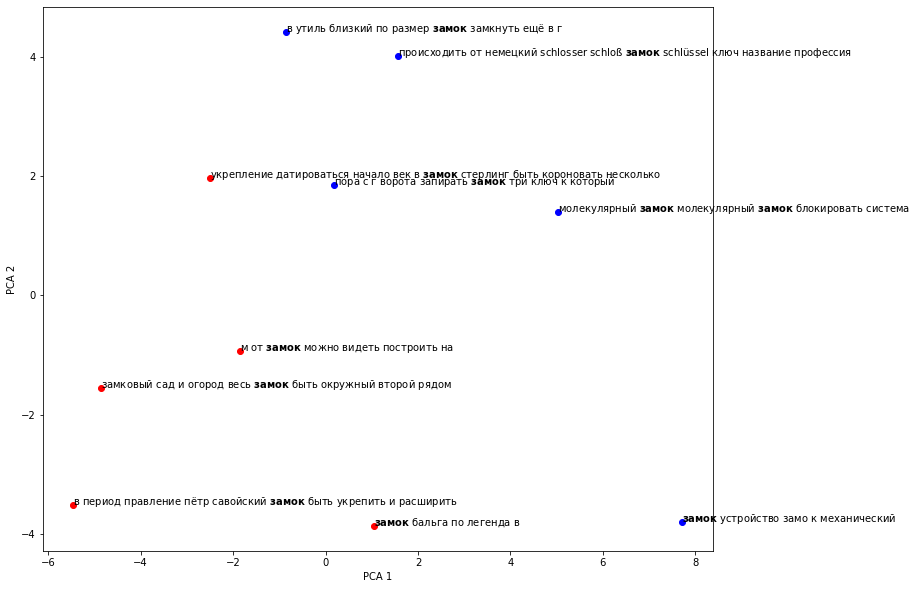

In [18]:
plot('замок', sentences, labels, X_reduce)

Что можно сделать с этими векторами в целях WSD?
* классификация
* кластеризация


# Задание (в группах)

Вариант 1:

- Напишите функцию, которая вычисляет центроид (средний вектор) каждого значения данного слова по всем контекстам из `train`.
- Напишите вторую функцию, которая принимает на вход слово и произвольный контекст с этим словом, а возвращает индекс значения слова в этом контексте: вычисляем контекстный вектор, сравниваем с центроидами значений, выбираем ближайшее. Можно также вывести насколько контекстов для этого значения из обучающего множества.


In [20]:
def get_centroids(word):
    contexts = train[train['word']==word]
    senses = set(contexts['gold_sense_id'].to_list())
    centroids = []
    for s in senses:
        s_contexts = contexts[contexts['gold_sense_id']==s]['context']
        X = np.vstack(get_elmo_vectors(word, s_contexts, model))
        s_centr = X.mean(axis=0)
        centroids.append(s_centr)
    return centroids

get_centroids('замок')

2021-11-25 11:47:34,562 : INFO : Warming up ELMo on 32 sentences...
2021-11-25 11:47:37,373 : INFO : Warming up finished.
2021-11-25 11:47:37,385 : INFO : Texts in the current batch: 32
2021-11-25 11:47:39,816 : INFO : Texts in the current batch: 32
2021-11-25 11:47:42,358 : INFO : Texts in the current batch: 32
2021-11-25 11:47:44,887 : INFO : Texts in the current batch: 4
2021-11-25 11:47:53,011 : INFO : Warming up ELMo on 32 sentences...
2021-11-25 11:47:55,875 : INFO : Warming up finished.
2021-11-25 11:47:55,889 : INFO : Texts in the current batch: 32
2021-11-25 11:47:58,067 : INFO : Texts in the current batch: 6


[array([ 0.29154891,  0.32626583, -0.04688291, ..., -0.72961826,
        -0.61872663,  0.4071331 ]),
 array([ 0.30177676,  0.25371078, -0.13949184, ..., -0.89925065,
        -0.50942994,  0.37480843])]

In [23]:
from scipy.spatial.distance import cosine

In [24]:
def choose_meaning(word, context, centroids):
    sense_v = get_elmo_vectors(word, [context], model)[0]
    return np.argmax([cosine(sense_v, c) for c in centroids])

new_context = 'В отличие от крепостей, кремлей или окруженных стенами городов Константинополя и Антиохии, замки не являлись общественным защитным сооружением, а были построены и принадлежали местным феодалам'
w = 'замок'
choose_meaning(w, new_context, get_centroids(w))

2021-11-25 11:53:58,214 : INFO : Warming up ELMo on 32 sentences...
2021-11-25 11:54:01,189 : INFO : Warming up finished.
2021-11-25 11:54:01,200 : INFO : Texts in the current batch: 32
2021-11-25 11:54:03,567 : INFO : Texts in the current batch: 32
2021-11-25 11:54:06,088 : INFO : Texts in the current batch: 32
2021-11-25 11:54:08,534 : INFO : Texts in the current batch: 4
2021-11-25 11:54:15,883 : INFO : Warming up ELMo on 32 sentences...
2021-11-25 11:54:18,292 : INFO : Warming up finished.
2021-11-25 11:54:18,303 : INFO : Texts in the current batch: 32
2021-11-25 11:54:20,442 : INFO : Texts in the current batch: 6
2021-11-25 11:54:27,896 : INFO : Warming up ELMo on 1 sentences...
2021-11-25 11:54:28,554 : INFO : Warming up finished.
2021-11-25 11:54:28,555 : INFO : Texts in the current batch: 1


[0.14752477655079, 0.2209048189680285]


1

Вариант 2:
- Выберите один их методов кластеризации:
  - [K-Means]()
  - [Affinity Propagation]()
  - или любой другой приятный вам метод из [sklearn.cluster]()
- Напишите функцию, которая будет принимать на вход слово, кластеризовать его контексты из `train` и вычислять ARI по сравнению с эталонной разметкой значений.
- (*) Если останется время, можно нарисовать получившуюся кластеризацию - с помощью функции `plot`, которая определена выше.

In [58]:
ARI = []
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context']
    gold_labels = grouped_df.get_group(key)['gold_sense_id'].to_list()
    X = get_elmo_vectors(key, texts, model)
    if len(X) != len(gold_labels):
        continue
    
    cluster = AffinityPropagation(damping=0.9)
    cluster.fit(X)
    labels = np.array(cluster.labels_) + 1
    
    ARI.append(adjusted_rand_score(gold_labels, labels))
    
    print(key, '  ', adjusted_rand_score(gold_labels, labels))
print(np.mean(ARI))

2021-11-24 14:29:14,900 : INFO : Warming up ELMo on 32 sentences...
2021-11-24 14:29:17,636 : INFO : Warming up finished.
2021-11-24 14:29:17,647 : INFO : Texts in the current batch: 32
2021-11-24 14:29:19,894 : INFO : Texts in the current batch: 24
2021-11-24 14:29:30,777 : INFO : Warming up ELMo on 32 sentences...
2021-11-24 14:29:33,391 : INFO : Warming up finished.
2021-11-24 14:29:33,411 : INFO : Texts in the current batch: 32
2021-11-24 14:29:35,682 : INFO : Texts in the current batch: 32
2021-11-24 14:29:37,939 : INFO : Texts in the current batch: 32
2021-11-24 14:29:40,431 : INFO : Texts in the current batch: 32
2021-11-24 14:29:43,017 : INFO : Texts in the current batch: 10


замок    0.05533693682115057


2021-11-24 14:29:52,507 : INFO : Warming up ELMo on 32 sentences...
2021-11-24 14:29:55,174 : INFO : Warming up finished.
2021-11-24 14:29:55,184 : INFO : Texts in the current batch: 32
2021-11-24 14:29:57,233 : INFO : Texts in the current batch: 32
2021-11-24 14:29:59,449 : INFO : Texts in the current batch: 32
2021-11-24 14:30:01,811 : INFO : Texts in the current batch: 14


лук    0.07607952778674816


2021-11-24 14:30:11,720 : INFO : Warming up ELMo on 32 sentences...
2021-11-24 14:30:14,398 : INFO : Warming up finished.
2021-11-24 14:30:14,409 : INFO : Texts in the current batch: 32
2021-11-24 14:30:16,689 : INFO : Texts in the current batch: 32
2021-11-24 14:30:18,960 : INFO : Texts in the current batch: 32
2021-11-24 14:30:21,431 : INFO : Texts in the current batch: 32
2021-11-24 14:30:23,769 : INFO : Texts in the current batch: 7


0.06570823230394937
